In [1]:
import os

# import sys
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import shap
import matplotlib.pyplot as plt

# import itertools
# import re
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
)

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

os.chdir("..")
from utils.utils import *
from shap_analysis.supporting_functions import *
from shap_analysis.plotting import *

os.chdir("..")

In [2]:
# load results of recursive feature elimination (rfe)
df_performances = pd.read_csv(f"data/output/results_rfe.csv", sep=";")
df_performances = prepare_performance_dataframe(df_performances, "features")

df_metadata = pd.read_csv(f"data/output/metadata_rfe.csv", sep=";")
df_metadata = prepare_metadata_dataframe(
    df_metadata, ["indices_training_set", "indices_val_set", "indices_test_set"]
)

df_data = pd.read_csv(df_metadata[col_file_path].unique()[0], sep=";")

## Selection of reduced GBT model 

In [3]:
# number of features of reduced gbt model
feature_count_threshold = 15

In [4]:
df_perf_all_split = df_performances.loc[
    (df_performances[col_feature_count] == feature_count_threshold)
    & (df_performances[ranking_mean_r2_desc] == 1),
    [col_run_id, mean_r2_cv_test],
]
split_id_best_model = df_perf_all_split.loc[
    df_perf_all_split[mean_r2_cv_test] == df_perf_all_split[mean_r2_cv_test].max(),
    col_run_id,
].values[0]
print("The id of train-test split with best performance: ", split_id_best_model)
print(
    "Further analysis focus of the best performing reduced model on this split identified during the hyper parameter optimization during the recursive feature elimination."
)

The id of train-test split with best performance:  4
Further analysis focus of the best performing reduced model on this split identified during the hyper parameter optimization during the recursive feature elimination.


#### Performance of the GBT models during RFE (Figure 2)

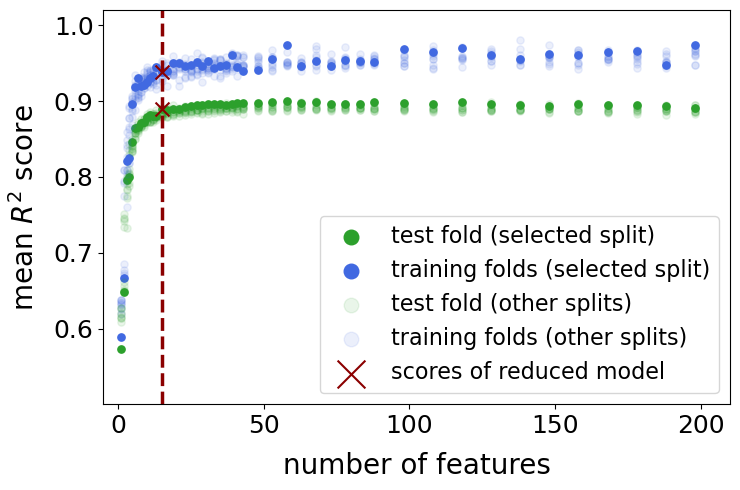

In [5]:
fig, ax = plt_performance(
    df_performances,
    perf_metric_test=mean_r2_cv_test,
    perf_metric_train=mean_r2_cv_train,
    list_runs=df_performances[col_run_id].unique(),
    x_max=210,
    x_min=-5,
    s=110,
    run_red_model=split_id_best_model,
    feat_count_red_model=feature_count_threshold,
    include_train_score=True,
    indicate_red_model=True,
)

#### Mean feature importances of the reduced model for all the 10 training-test splits (Figure 3)

In [6]:
model_dict = get_fitted_models(
    df_perf=df_performances,
    df_metadata=df_metadata,
    feat_count_red_model=feature_count_threshold,
    target_feat=col_power_accum_pv,
    train_on_train_val=True,
)
df_mean_shap = get_mean_shap(
    model_dict,
    feature_count_threshold=feature_count_threshold,
    df_perf=df_performances,
    df_metadata=df_metadata,
)
features = list(df_mean_shap.index)
features.remove(mean_r2_cv_test)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightG

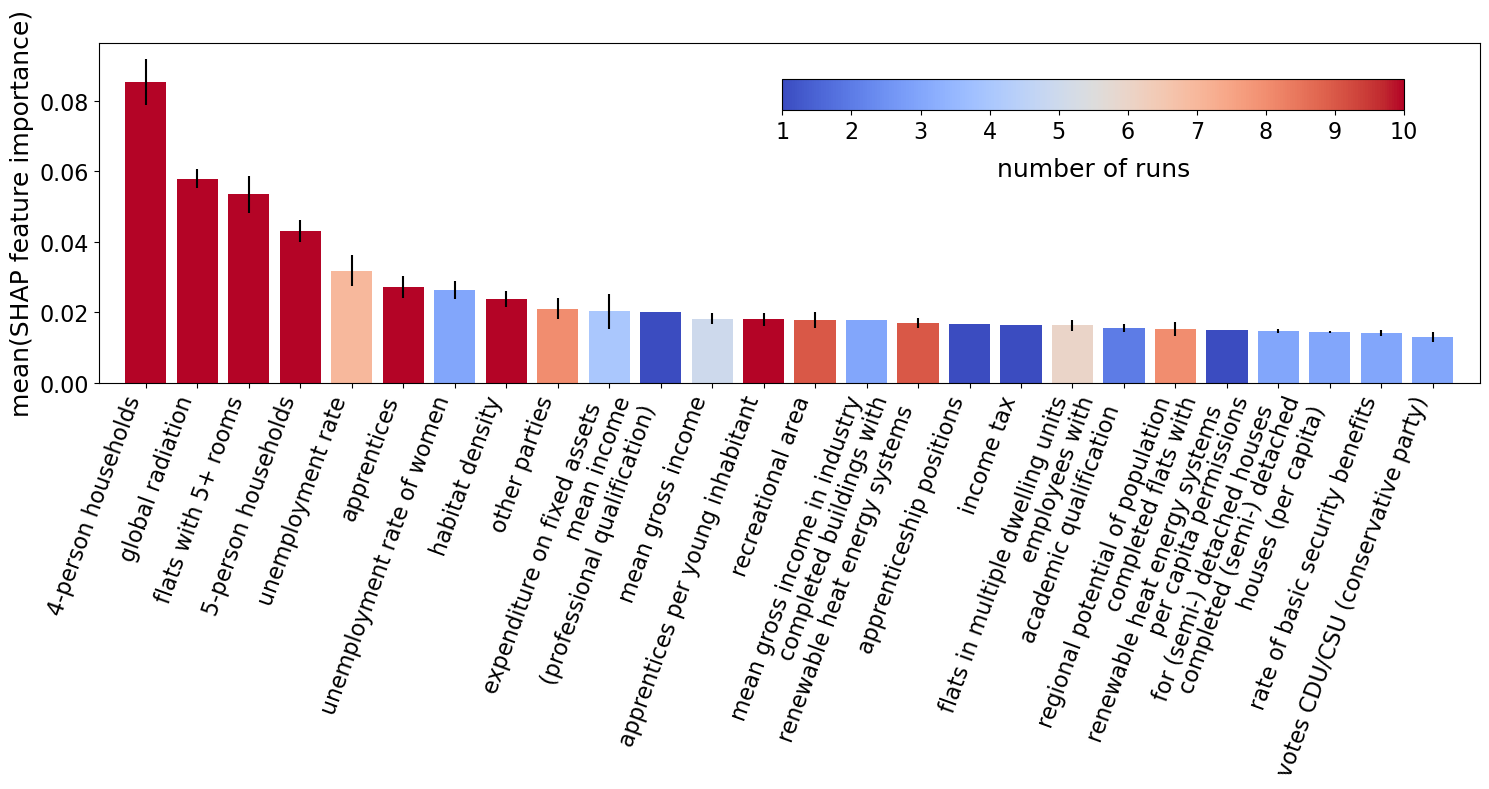

In [7]:
fig, ax = hbar_shap_feature_imp(df_run_eval_input=df_mean_shap, features=features)
plt.show()

## SHAP Analysis of the selected reduced GBT model 

In [8]:
idx_train = df_metadata.loc[
    df_metadata[col_run_id] == split_id_best_model, col_idx_train
].values[0]
idx_val = df_metadata.loc[
    df_metadata[col_run_id] == split_id_best_model, col_idx_val
].values[0]
idx_test = df_metadata.loc[
    df_metadata[col_run_id] == split_id_best_model, col_idx_test
].values[0]

In [9]:
# Get reduced model and the input data for the reduced model
df_performance_red_model = df_performances.loc[
    (df_performances[col_run_id] == split_id_best_model)
    & (df_performances[col_feature_count] == feature_count_threshold)
    & (df_performances[ranking_mean_r2_desc] == 1),
    :,
]
X_red_model = df_data[df_performance_red_model[col_features].values[0]]
red_model = model_dict[split_id_best_model]

# saving predictions to plot in map
y_pred = red_model.predict(X_red_model)
df_pred = pd.DataFrame({col_id_ma: df_data[col_id_ma], col_predictions: y_pred})
df_pred.to_csv("data/output/predictions_rfe.csv", sep=";", index=False)

# Target and predicted values on training and test set
y_train = df_data[col_power_accum_pv].iloc[idx_train + idx_val]
y_test = df_data[col_power_accum_pv].iloc[idx_test]
y_train_pred = y_pred[idx_train + idx_val]
y_test_pred = y_pred[idx_test]

# Compute SHAP and SHAP interaction values for the reduced model
tree_explainer = shap.explainers.Tree(red_model)
shap_values = tree_explainer.shap_values(X_red_model)
interaction_values = tree_explainer.shap_interaction_values(X_red_model)

#### Performance of reduced GBT model

In [10]:
print("+++ performance metrics (reduced GBT) +++")
print(
    f"R2 score: {r2_score(y_true=y_train, y_pred=y_train_pred)} (training), {r2_score(y_true=y_test, y_pred=y_test_pred)} (test)"
)
print(
    f"mae: {mean_absolute_error(y_true=y_train, y_pred=y_train_pred)} (training), {mean_absolute_error(y_true=y_test, y_pred=y_test_pred)} (test)"
)
print(
    f"mape: {mean_absolute_percentage_error(y_true=y_train, y_pred=y_train_pred)} (training), {mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)} (test)"
)

+++ performance metrics (reduced GBT) +++
R2 score: 0.9274074060528184 (training), 0.8848073993413559 (test)
mae: 0.06810125495429814 (training), 0.08431299842190057 (test)
mape: 0.17510530618259723 (training), 0.20793127157256008 (test)


#### Dependence plots (Figure 4)

In [11]:
fig_size = (8, 6.5)

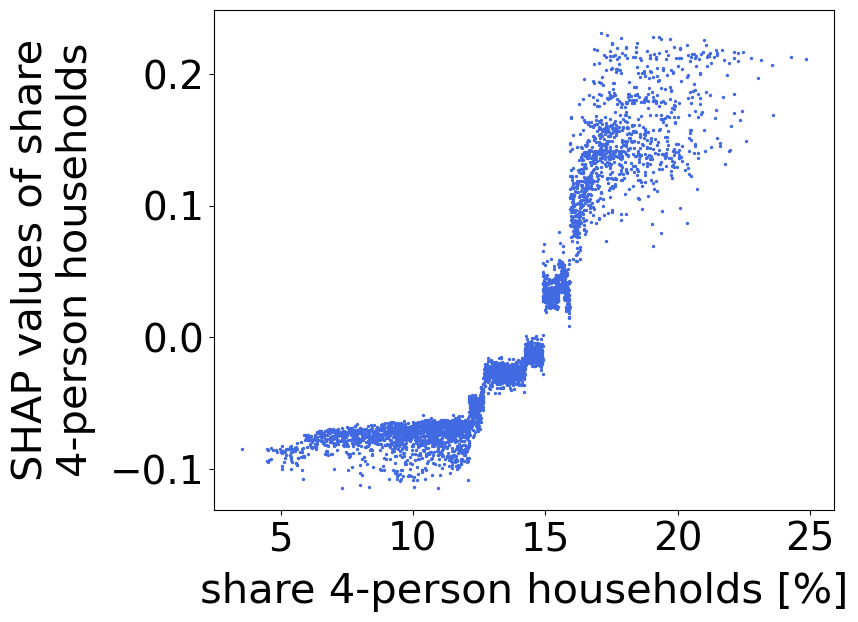

In [12]:
fig, ax = dependence_plot(
    X_red_model,
    shap_values,
    feature="share 4-person households",
    x_label="share 4-person households [%]",
    fig_size=fig_size,
    y_label="SHAP values of share\n4-person households",
)
plt.show()

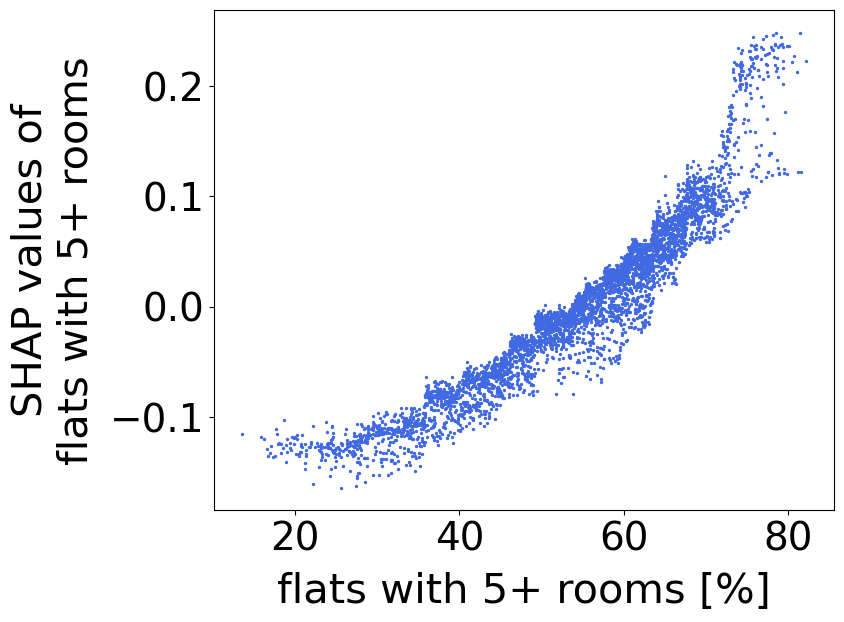

In [13]:
fig, ax = dependence_plot(
    X_red_model,
    shap_values,
    feature="flats with 5+ rooms",
    x_label="flats with 5+ rooms [%]",
    fig_size=fig_size,
    y_label="SHAP values of\nflats with 5+ rooms",
)
plt.show()

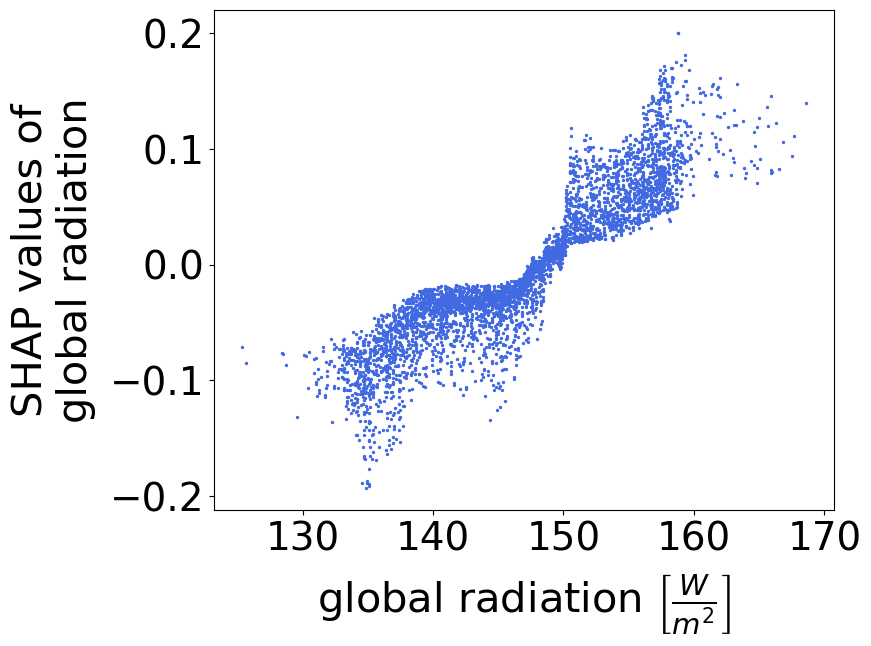

In [14]:
fig, ax = dependence_plot(
    X_red_model,
    shap_values,
    feature="global radiation",
    x_label=r"global radiation $\left[\frac{W}{m^2}\right]$",
    fig_size=fig_size,
    y_label="SHAP values of\nglobal radiation",
)
plt.show()

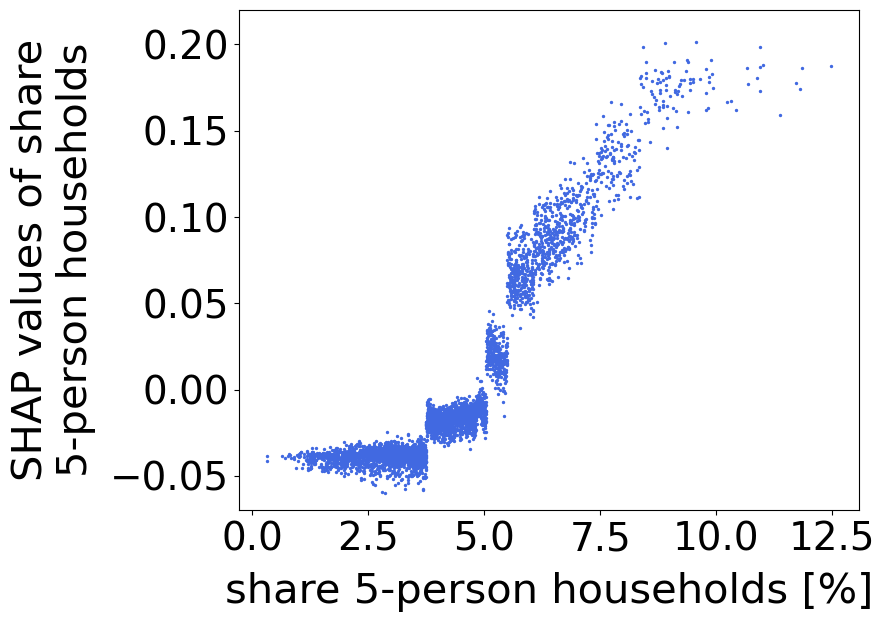

In [15]:
fig, ax = dependence_plot(
    X_red_model,
    shap_values,
    feature="share 5-person households",
    x_label="share 5-person households [%]",
    fig_size=fig_size,
    y_lim=(-0.07, 0.22),
    y_label="SHAP values of share\n5-person households",
)
plt.show()

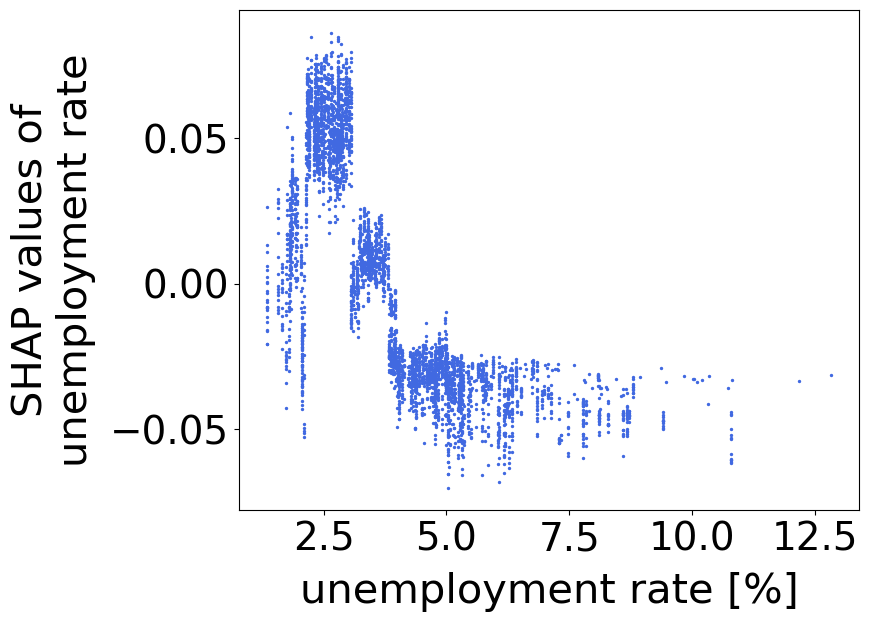

In [16]:
fig, ax = dependence_plot(
    X_red_model,
    shap_values,
    feature="unemployment rate",
    x_label="unemployment rate [%]",
    fig_size=fig_size,
    y_label="SHAP values of\nunemployment rate",
)
plt.show()

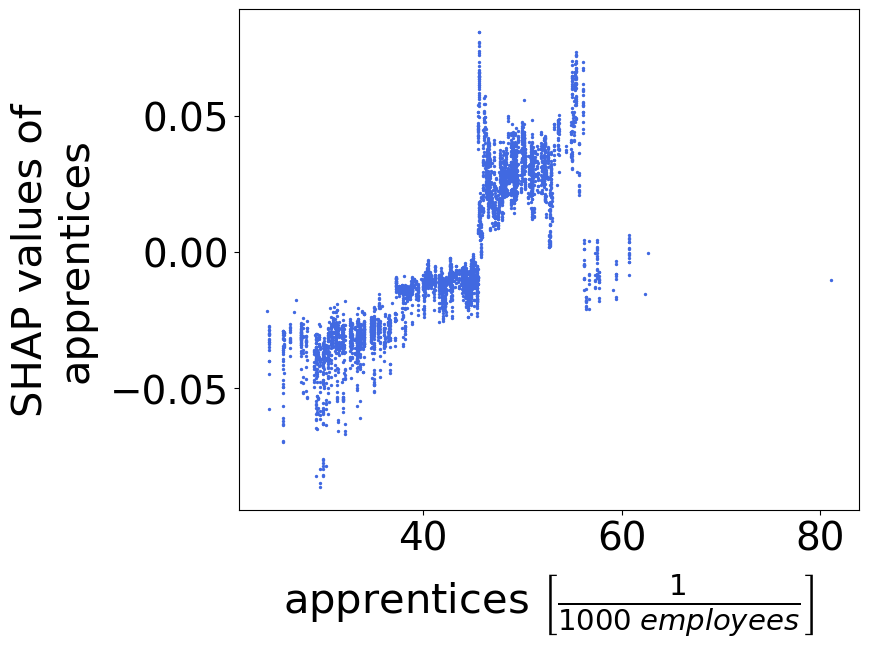

In [17]:
fig, ax = dependence_plot(
    X_red_model,
    shap_values,
    feature="apprentices",
    x_label=r"apprentices $\left[\frac{1}{1000\;employees}\right]$",
    fig_size=fig_size,
    y_label="SHAP values of\napprentices",
)
plt.show()

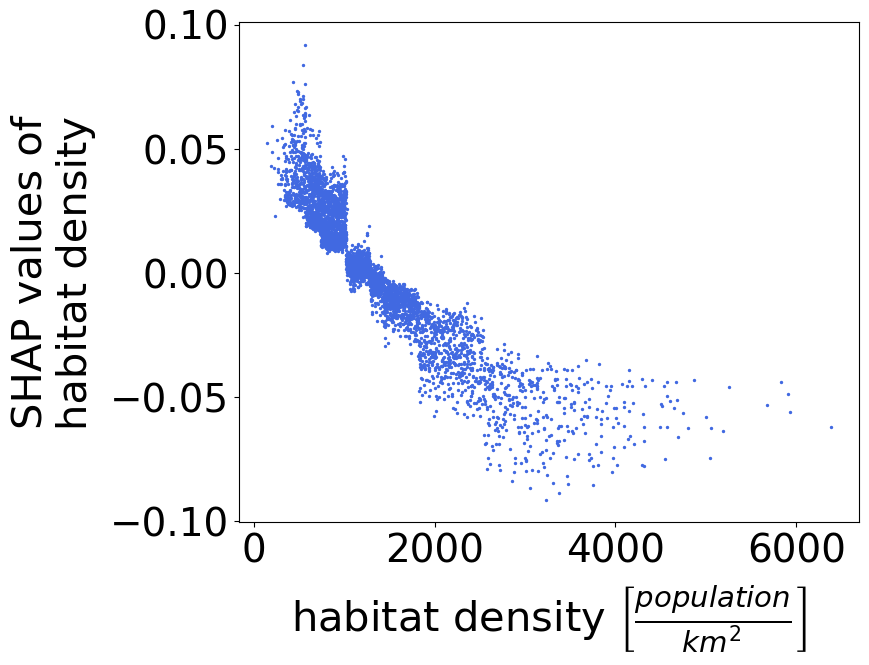

In [18]:
fig, ax = dependence_plot(
    X_red_model,
    shap_values,
    feature="habitat density",
    x_label=r"habitat density $\left[\frac{population}{km^2}\right]$",
    fig_size=fig_size,
    y_label="SHAP values of\nhabitat density",
)
plt.show()

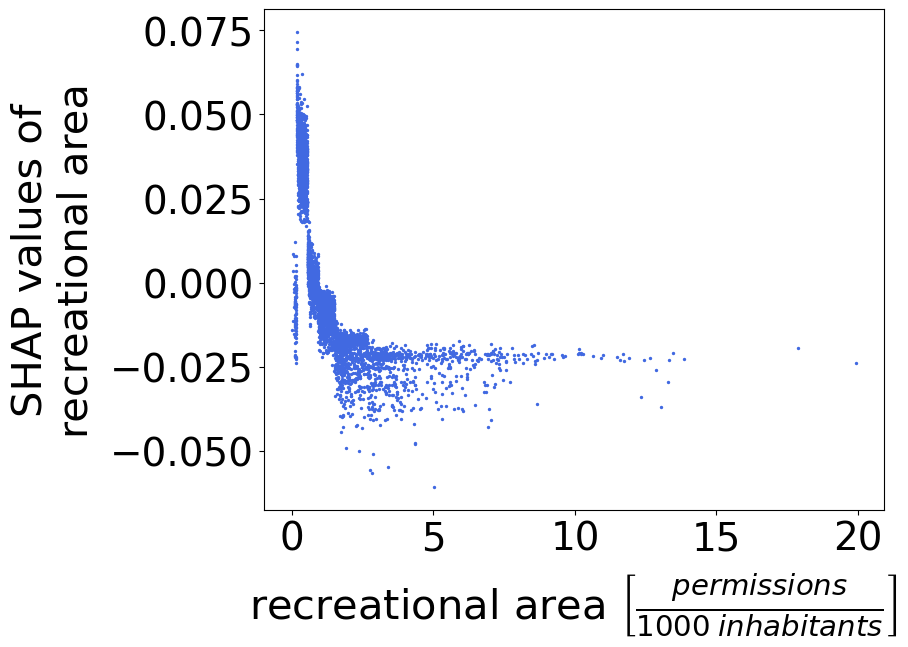

In [19]:
fig, ax = dependence_plot(
    X_red_model,
    shap_values,
    feature="recreational area",
    x_label=r"recreational area $\left[\frac{permissions}{1000\;inhabitants}\right]$",
    fig_size=fig_size,
    y_label="SHAP values of\nrecreational area",
)
plt.show()

## Analysis of SHAP interaction values

#### Heatmap of SHAP interaction values (Figure 5)

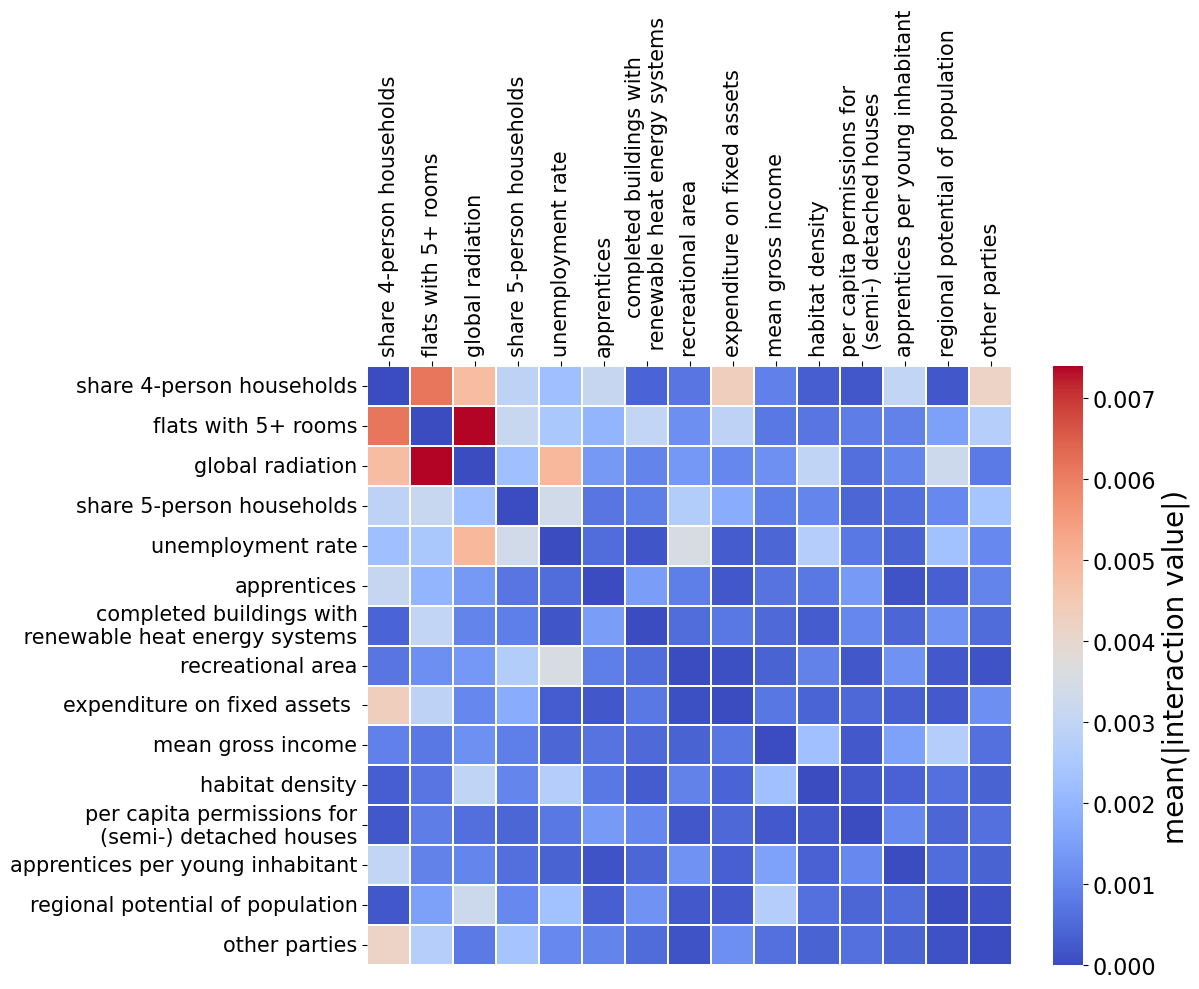

In [20]:
# adjust tick labels
rename_tick_dict = {
    "employees with academic qualification": "employees with academic\n qualification",
    "completed buildings with renewable heat energy systems": "completed buildings with\n renewable heat energy systems",
    "completed (semi-) detached houses (per capita)": "completed (semi-) detached\n houses (per capita)",
    "per capita permissions for (semi-) detached houses": "per capita permissions for\n(semi-) detached houses",
}
fig, ax = heatmap_interactions(
    X_red_model, interaction_values, feature_name_dict=rename_tick_dict
)
plt.show()

#### Disentangling SHAP values into main effects and feature interactions (Figure 6)

Example: Decomposition for the feature "flats with 5+ rooms"

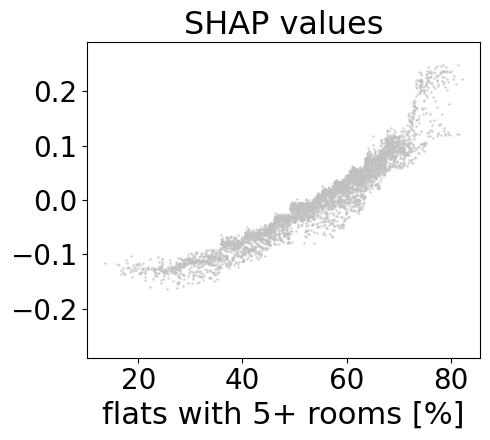

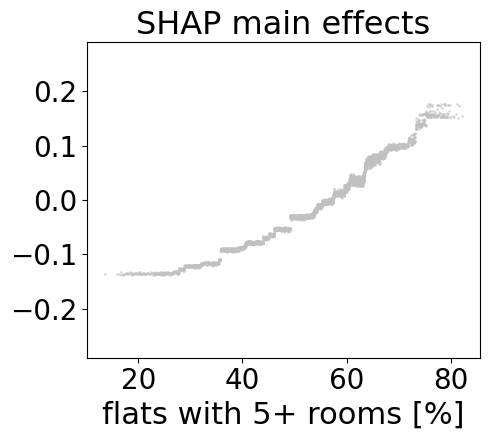

In [21]:
feat = "flats with 5+ rooms"
tick_size = 18

dependence_plot_main_effect(
    X=X_red_model,
    shap_values=shap_values,
    feature="flats with 5+ rooms",
    plot_main_effect=False,
    x_lim=None,
    y_lim=(-0.29, 0.29),
    y_label="SHAP values",
    x_label="flats with 5+ rooms [%]",
    fig_size=(5, 4.5),
    font_size=tick_size + 4,
    tick_size=tick_size + 2,
)
plt.show()
plt.close(fig)
dependence_plot_main_effect(
    X=X_red_model,
    shap_values=interaction_values,
    feature="flats with 5+ rooms",
    plot_main_effect=True,
    x_lim=None,
    y_lim=(-0.29, 0.29),
    y_label="SHAP main effects",
    x_label="flats with 5+ rooms [%]",
    fig_size=(5, 4.5),
    font_size=tick_size + 4,
    tick_size=tick_size + 2,
)
plt.show()
plt.close()

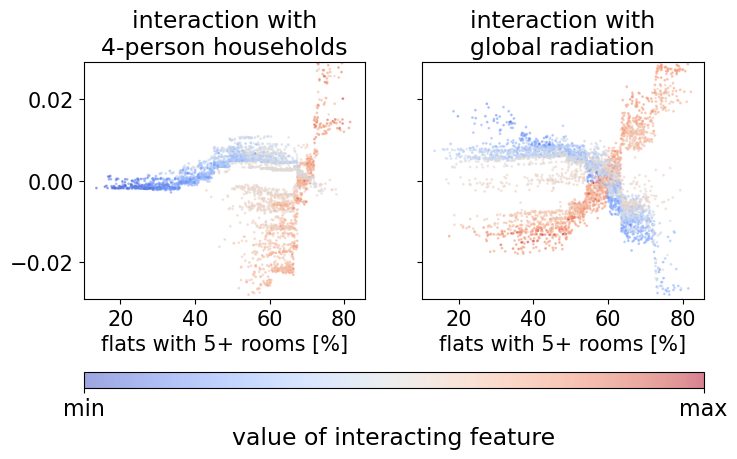

In [22]:
feat = "flats with 5+ rooms"
font_size = 15
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(8, 5))

scatter, ax[0] = dependence_plot_interactions(
    X=X_red_model,
    interaction_vals=interaction_values,
    feature=feat,
    interaction_feature="share 4-person households",
    ax=ax[0],
    x_label=None,
    y_label=None,
    cb_label=None,
    x_lim=None,
    y_lim=(-0.029, 0.029),
    y_ticks=False,
    title="interaction with\n4-person households",
    font_size=font_size + 2,
    tick_size=font_size,
)
_, ax[1] = dependence_plot_interactions(
    X=X_red_model,
    interaction_vals=interaction_values,
    feature=feat,
    interaction_feature="global radiation",
    ax=ax[1],
    x_label=None,
    y_label=None,
    cb_label=None,
    x_lim=None,
    y_lim=(-0.029, 0.029),
    y_ticks=False,
    title="interaction with\nglobal radiation",
    font_size=font_size + 2,
    tick_size=font_size,
)
ax[0].set_xlabel("flats with 5+ rooms [%]", fontsize=font_size)
ax[1].set_xlabel("flats with 5+ rooms [%]", fontsize=font_size)
plt.subplots_adjust(bottom=0.15, hspace=0.25)
plt.locator_params(axis="x", nbins=5)

cbar = fig.colorbar(
    scatter,
    ax=ax,
    orientation="horizontal",
    ticks=[
        X_red_model["share 4-person households"].min(),
        X_red_model["share 4-person households"].max(),
    ],
    pad=0.2,
    aspect=40,
)  # ax=cb_ax,
cbar.ax.set_xticklabels(["min", "max"], size=font_size + 1)
cbar.set_label("value of interacting feature", fontsize=font_size + 2)
plt.show()
plt.close()

## Supplementary Information: Additional SHAP analyses of main reduced GBT model

In [23]:
top_15_features = [
    "share 4-person households",
    "flats with 5+ rooms",
    "global radiation",
    "share 5-person households",
    "unemployment rate",
    "apprentices",
    "habitat density",
    "recreational area",
    "completed buildings with renewable heat energy systems",
    "apprentices per young inhabitant",
    "expenditure on fixed assets ",
    "other parties",
    "mean gross income",
    "per capita permissions for (semi-) detached houses",
    "regional potential of population",
]
interaction_feat_list = [
    "flats with 5+ rooms"
    if feature in ["share 4-person households", "share 5-person households"]
    else "share 4-person households"
    for feature in top_15_features
]

x_lab_additions = [
    "[%]",
    "[%]",
    r"$\left[\frac{W}{m^2}\right]$",
    "[%]",
    "[%]",
    r"$\left[\frac{1}{1000\;employees}\right]$",
    r"$\left[\frac{population}{km^2}\right]$",
    "[%]",
    "[%]",
    "[%]",
    r"$\left[\frac{€}{inhabitant}\right]$",
    "[%]",
    r"$\left[\frac{€}{employee}\right]$",
    r"$\left[\frac{permissions}{1000\;inhabitants}\right]$",
    "",
]
y_label_dict = {
    "share 4-person households": "SHAP values of share\n4-person households",
    "share 5-person households": "SHAP values of share\n5-person households",
    "completed buildings with renewable heat energy systems": "SHAP values of completed buildings\nwith renewable heat energy systems",
    "apprentices per young inhabitant": "SHAP values of apprentices\nper young inhabitant",
    "expenditure on fixed assets ": "SHAP values of\nexpenditure on fixed assets",
    "per capita permissions for (semi-) detached houses": "SHAP values of permissions\nfor (semi-) detached houses",
    "regional potential of population": "SHAP values of regional\npotential of population",
}

fig_size_interaction = (9, 6.5)
threshold_inverse_alpha = 38

In [24]:
df_mean = pd.DataFrame(df_data[top_15_features].iloc[idx_train + idx_val].mean()).T
df_std = pd.DataFrame(df_data[top_15_features].iloc[idx_train + idx_val].std(ddof=0)).T
df_coef_lasso_complete = pd.read_csv("data/output/benchmarking_lasso.csv", sep=";")
alpha_lasso = df_coef_lasso_complete.loc[
    1 / df_coef_lasso_complete[col_alpha] <= threshold_inverse_alpha, col_alpha
].min()
df_coef_lasso = df_coef_lasso_complete[
    (df_coef_lasso_complete[col_run_id] == split_id_best_model)
    & (df_coef_lasso_complete[col_alpha] == alpha_lasso)
]

print("Parameter alpha of reduced lasso model:", alpha_lasso)

Parameter alpha of reduced lasso model: 0.026324


#### Dependence plots for all 15 features including interactions and results on LASSO model (SI figure 7)

In [25]:
for feat, interacting_feat, label_extension in zip(
    top_15_features, interaction_feat_list, x_lab_additions
):
    y_lim = None
    if feat == "share 5-person households":
        y_lim = (-0.07, 0.22)
    elif feat == "other parties":
        y_lim = (-0.051, 0.076)
    elif feat == "per capita permissions for (semi-) detached houses":
        y_lim = (-0.07, 0.1)
    if feat in y_label_dict:
        y_label = y_label_dict[feat]
    else:
        y_label = "SHAP values of\n" + feat
    if interacting_feat == "share 4-person households":
        cb_label = "share 4-person\nhouseholds [%]"
    else:
        cb_label = interacting_feat + " [%]"
    if feat == "completed buildings with renewable heat energy systems":
        feat_lab = "completed buildings with\nrenewable heat energy systems"
    elif feat == "per capita permissions for (semi-) detached houses":
        feat_lab = "permissions for (semi-) detached houses"
    elif feat == "regional potential of population":
        feat_lab = "regional potential of population\n[1000 inhabitants]"
    else:
        feat_lab = feat
    if df_coef_lasso[feat].values[0] != 0:
        fig, ax = dependence_plot(
            X_red_model,
            shap_values,
            feature=feat,
            interaction_feature=interacting_feat,
            lasso_mean=df_mean[feat].values[0],
            lasso_std=df_std[feat].values[0],
            lasso_coef=df_coef_lasso[feat].values[0],
            x_label=feat_lab + " " + label_extension,
            cb_label=cb_label,
            fig_size=fig_size_interaction,
            y_lim=y_lim,
            y_label=y_label,
        )
    else:
        fig, ax = dependence_plot(
            X_red_model,
            shap_values,
            feature=feat,
            interaction_feature=interacting_feat,
            x_label=feat_lab + " " + label_extension,
            cb_label=cb_label,
            fig_size=fig_size_interaction,
            y_lim=y_lim,
            y_label=y_label,
        )
    # plt.show()
    if feat == "per capita permissions for (semi-) detached houses":
        plt.savefig(f'interaction_dep_plt_{feat}.pdf',format='pdf',bbox_inches="tight")
    plt.close()

#### Analyses of SHAP interaction values of 'share 4-person households' and 'global radiation' (SI figure 8 and 9)

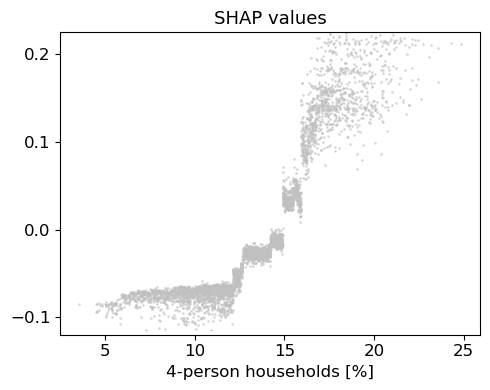

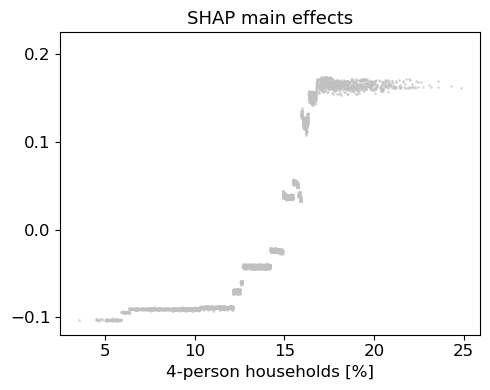

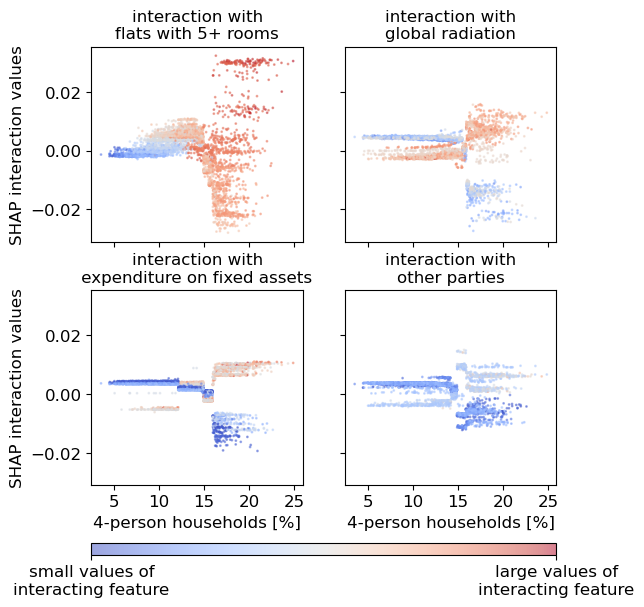

In [26]:
feat = "share 4-person households"

dependence_plot_main_effect(
    X=X_red_model,
    shap_values=shap_values,
    feature=feat,
    plot_main_effect=False,
    y_lim=(-0.12, 0.225),
    x_lim=None,
    y_label="SHAP values",
    x_label="4-person households [%]",
)
plt.show()
plt.close(fig)

dependence_plot_main_effect(
    X=X_red_model,
    shap_values=interaction_values,
    feature=feat,
    plot_main_effect=True,
    y_lim=(-0.12, 0.225),
    x_lim=None,
    y_label="SHAP main effects",
    x_label="4-person households [%]",
)
plt.show()
plt.close(fig)

# interactions of 4-person households
feat = "share 4-person households"

fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=(6, 8))

scatter, ax[0, 0] = dependence_plot_interactions(
    X=X_red_model,
    interaction_vals=interaction_values,
    feature=feat,
    interaction_feature="flats with 5+ rooms",
    ax=ax[0, 0],
    x_label=None,
    y_label=None,
    cb_label=None,
    x_lim=None,
    y_lim=None,
    title="interaction with\nflats with 5+ rooms",
)
_, ax[0, 1] = dependence_plot_interactions(
    X=X_red_model,
    interaction_vals=interaction_values,
    feature=feat,
    interaction_feature="global radiation",
    ax=ax[0, 1],
    x_label=None,
    y_label=None,
    cb_label=None,
    x_lim=None,
    y_lim=None,
    title="interaction with\nglobal radiation",
)
_, ax[1, 0] = dependence_plot_interactions(
    X=X_red_model,
    interaction_vals=interaction_values,
    feature=feat,
    interaction_feature="expenditure on fixed assets ",
    ax=ax[1, 0],
    x_label=None,
    y_label=None,
    cb_label=None,
    x_lim=None,
    y_lim=None,
    title=None,
)
_, ax[1, 1] = dependence_plot_interactions(
    X=X_red_model,
    interaction_vals=interaction_values,
    feature=feat,
    interaction_feature="other parties",
    ax=ax[1, 1],
    x_label=None,
    y_label=None,
    cb_label=None,
    x_lim=None,
    y_lim=None,
    title="interaction with\nother parties",
)
ax[1, 0].set_xlabel("4-person households [%]", fontsize=12)
ax[1, 1].set_xlabel("4-person households [%]", fontsize=12)
ax[0, 0].set_ylabel("SHAP interaction values", fontsize=12)
ax[1, 0].set_ylabel("SHAP interaction values", fontsize=12)
plt.subplots_adjust(bottom=0.15, hspace=0.25)
plt.locator_params(axis="x", nbins=5)

cbar = fig.colorbar(
    scatter,
    ax=ax,
    orientation="horizontal",
    ticks=[
        X_red_model["flats with 5+ rooms"].min(),
        X_red_model["flats with 5+ rooms"].max(),
    ],
    pad=0.1,
    aspect=40,
)  # ax=cb_ax,
cbar.ax.set_xticklabels(
    ["small values of\ninteracting feature", "large values of\ninteracting feature"],
    size=12,
)
plt.show()
plt.close()

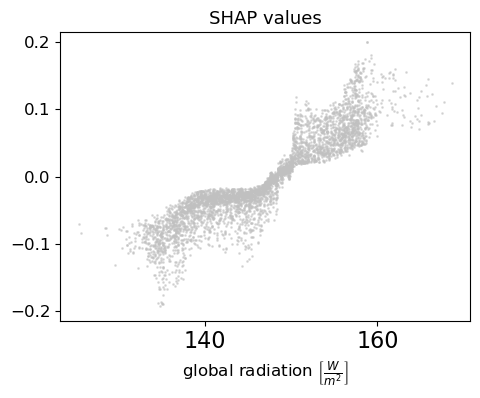

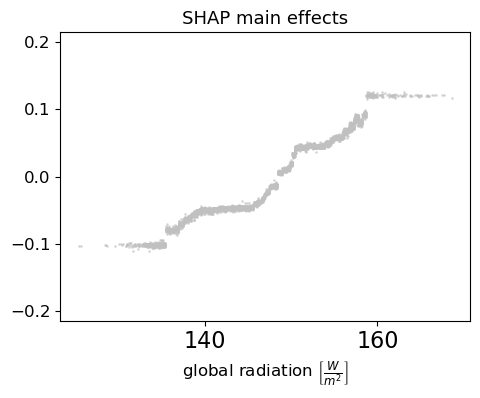

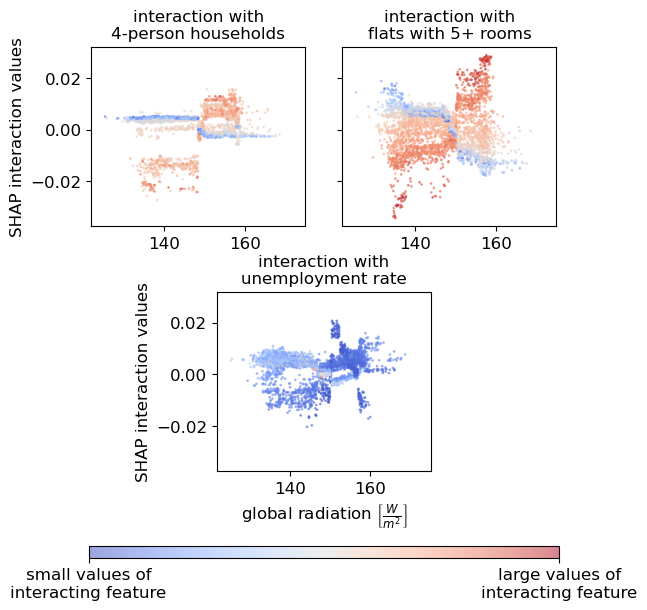

In [27]:
feat = "global radiation"
y_lim = (-0.215, 0.215)

dependence_plot_main_effect(
    X=X_red_model,
    shap_values=shap_values,
    feature=feat,
    plot_main_effect=False,
    x_lim=None,
    y_lim=y_lim,
    y_label="SHAP values",
    x_label=r"global radiation $\left[\frac{W}{m^2}\right]$",
)
plt.xticks(ticks=[140, 160], size=16)
plt.close(fig)
dependence_plot_main_effect(
    X=X_red_model,
    shap_values=interaction_values,
    feature=feat,
    plot_main_effect=True,
    x_lim=None,
    y_lim=y_lim,
    y_label="SHAP main effects",
    x_label=r"global radiation $\left[\frac{W}{m^2}\right]$",
)
plt.xticks(ticks=[140, 160], size=16)
plt.close(fig)

x_lim = (122, 175)
y_lim = (-0.0375, 0.032)

gs = gridspec.GridSpec(
    4, 4, hspace=0.75, wspace=0.42, height_ratios=[0.5, 0.4, 1, 0.85]
)

fig = plt.figure(figsize=(6, 8))
fig.subplots_adjust(bottom=0.2, hspace=5)
ax0 = fig.add_subplot(gs[:2, :2])
scatter, ax1 = dependence_plot_interactions(
    X=X_red_model,
    interaction_vals=interaction_values,
    feature=feat,
    interaction_feature="share 4-person households",
    ax=ax0,
    x_label=None,
    y_label=None,
    cb_label=None,
    x_lim=x_lim,
    y_lim=y_lim,
    y_ticks=False,
    title="interaction with\n4-person households",
)
ax0.set_ylabel("SHAP interaction values", fontsize=12)

ax1 = fig.add_subplot(gs[:2, 2:])
_, ax1 = dependence_plot_interactions(
    X=X_red_model,
    interaction_vals=interaction_values,
    feature=feat,
    interaction_feature="flats with 5+ rooms",
    ax=ax1,
    x_label=None,
    y_label=None,
    cb_label=None,
    x_lim=x_lim,
    y_lim=y_lim,
    y_ticks=False,
    title="interaction with\nflats with 5+ rooms",
)
plt.yticks(ticks=[-0.02, 0, 0.02], labels=[])

ax2 = fig.add_subplot(gs[2:, 1:3])
_, ax2 = dependence_plot_interactions(
    X=X_red_model,
    interaction_vals=interaction_values,
    feature=feat,
    interaction_feature="unemployment rate",
    ax=ax2,
    x_label=None,
    y_label=None,
    cb_label=None,
    x_lim=x_lim,
    y_lim=y_lim,
    y_ticks=False,
    title="interaction with\nunemployment rate",
)
ax2.set_ylabel("SHAP interaction values", fontsize=12)
ax2.set_xlabel(r"global radiation $\left[\frac{W}{m^2}\right]$", fontsize=12)

plt.locator_params(axis="x", nbins=5)

cb = plt.colorbar(
    scatter,
    ax=[ax2],
    orientation="horizontal",
    shrink=2.2,
    aspect=40,
    ticks=[
        X_red_model["share 4-person households"].min(),
        X_red_model["share 4-person households"].max(),
    ],
    pad=0.25,
)
cb.ax.set_xticklabels(
    ["small values of\ninteracting feature", "large values of\ninteracting feature"],
    size=12,
)

plt.show()
plt.close()